# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

file_path = '/content/drive/My Drive/data/vehicles.csv'
cars = pd.read_csv(file_path)

In [5]:
cars.sample(5)  # Show first 5 rows

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
122526,7315765486,atlanta,10500,2013.0,chrysler,town & country,NaN,6 cylinders,gas,92984.0,clean,automatic,2C4RC1BG2DR689128,fwd,NaN,NaN,grey,ga
236264,7306604562,fayetteville,0,2017.0,subaru,outback,NaN,4 cylinders,gas,53760.0,clean,automatic,4S4BSACC3H3381802,4wd,NaN,SUV,blue,nc
312265,7312064839,bend,0,2013.0,ford,f-250,NaN,8 cylinders,diesel,91555.0,clean,automatic,1FT7W2BT5DEB69844,4wd,NaN,truck,NaN,or
59631,7303132109,santa barbara,5799,2017.0,chevrolet,spark ls hatchback,excellent,4 cylinders,gas,0.0,NaN,automatic,KL8CB6SA4HC702261,NaN,NaN,hatchback,NaN,ca
127119,7313975202,statesboro,28249,2016.0,toyota,tundra double cab,NaN,8 cylinders,gas,78000.0,clean,automatic,5TFRW5F17GX212284,NaN,NaN,pickup,NaN,ga


In [6]:
cars.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [7]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

**Feature Analysis:**


Based on the data, I think Price is the target column that we want to predict.

Important Features:
* Numerical:
  * year
  * odometer
* Categorical:
  * cylinders
  * drive
  * type
  * manufacturer
  * model
  * condition
  * fuel
  * transmission
  * title_status


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [8]:
def show_missing_data(df):
  na_counts = df.isna().sum()
  na_percent = df.isna().mean() * 100

  na_summary = pd.concat([na_counts, na_percent], axis=1)
  na_summary.columns = ['NA Count', 'NA Percentage']
  na_summary.sort_values(by='NA Percentage', ascending=False, inplace=True)

  na_summary = na_summary[
      (na_summary['NA Count'] > 0) &
      (na_summary['NA Percentage'] > 0)
  ]
  print(na_summary)

show_missing_data(cars)

              NA Count  NA Percentage
size            306361      71.767476
cylinders       177678      41.622470
condition       174104      40.785232
VIN             161042      37.725356
drive           130567      30.586347
paint_color     130203      30.501078
type             92858      21.752717
manufacturer     17646       4.133714
title_status      8242       1.930753
model             5277       1.236179
odometer          4400       1.030735
fuel              3013       0.705819
transmission      2556       0.598763
year              1205       0.282281


**Analysis**

**🔴 Drop These Columns**

| Column         | Missing % | Reason for Removal                                                                 |
|----------------|-----------|-------------------------------------------------------------------------------------|
| `size`         | 71.8%     | Too many missing values; vague feature with limited predictive value.              |
| `VIN`          | 37.7%     | Unique identifier per vehicle; no predictive power and cannot be imputed.          |
| `paint_color`  | 30.5%     | Subjective feature; limited impact on price; high missing rate.                    |
| `drive`        | 30.6%     | Potentially useful (FWD, AWD), but high missingness and hard to impute accurately. |

<br><br>
**🟡 Keep with Imputation or Default Values**

| Column         | Missing % | Reason for Retention                                                               |
|----------------|-----------|-------------------------------------------------------------------------------------|
| `cylinders`    | 41.6%     | Represents engine size; strong signal for price. Impute as `'unknown'`.            |
| `condition`    | 40.8%     | Impacts vehicle price; fill missing with `'unknown'`.                              |
| `type`         | 21.8%     | Represents body style (SUV, sedan, etc.); relevant to price. Fill with `'unknown'`.|

<br><br>
**Drop Rows for these columns:**
* Manufacturer (Brand reputation affects price.)
* model (Curical to Car identification)
* title_status (lets keep the feature)
* odometer, fuel, transmission, year, (Affects price)



**Feature Analysis:**

So, based on NA columns and above analysis, this is what I think we should use

Important Features:
* Numerical:
  * year
  * odometer
* Categorical:
  * manufacturer
  * model
  * cylinders   
  * condition
  * type
  * fuel
  * transmission
  * title_status

<Axes: >

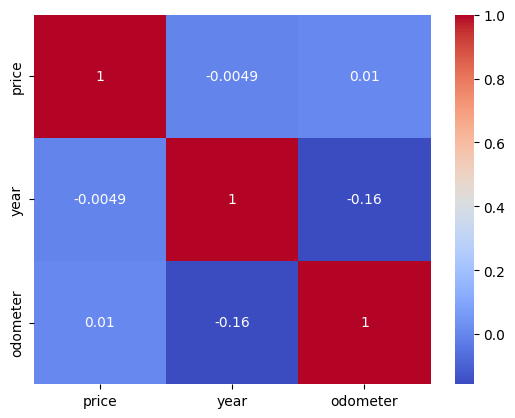

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = cars[['price', 'year', 'odometer']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')


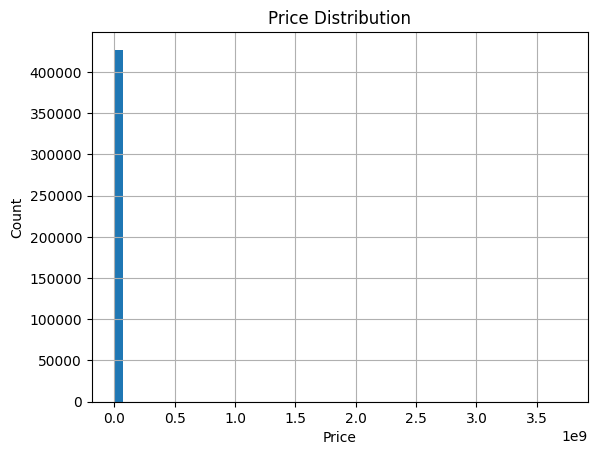

In [10]:
import matplotlib.pyplot as plt
cars['price'].hist(bins=50)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Price Distribution')
plt.show()

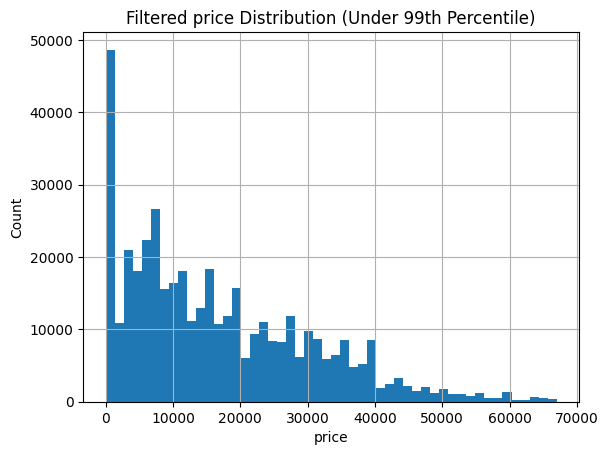

In [11]:
# Lets remove outliers to see the plot
def plot_distribution(cars, column, quantile):
  filtered = cars[cars[column] < cars[column].quantile(quantile)]

  filtered[column].hist(bins=50)
  plt.xlabel(column)
  plt.ylabel('Count')
  plt.title('Filtered ' + column + ' Distribution (Under 99th Percentile)')
  plt.show()


plot_distribution(cars, 'price', 0.99)

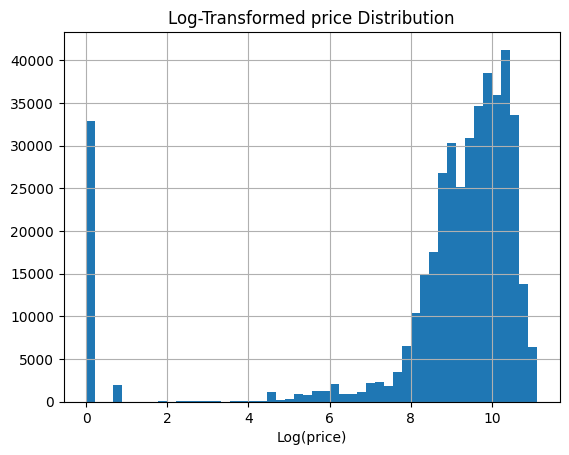

In [12]:
import numpy as np

def plot_log_distribution(cars, column, quantile):

  filtered = cars[cars[column] < cars[column].quantile(quantile)]
  filtered[column].apply(np.log1p).hist(bins=50)
  plt.xlabel('Log(' + column + ')')
  plt.title('Log-Transformed ' + column + ' Distribution')
  plt.show()

plot_log_distribution(cars, 'price', 0.99)

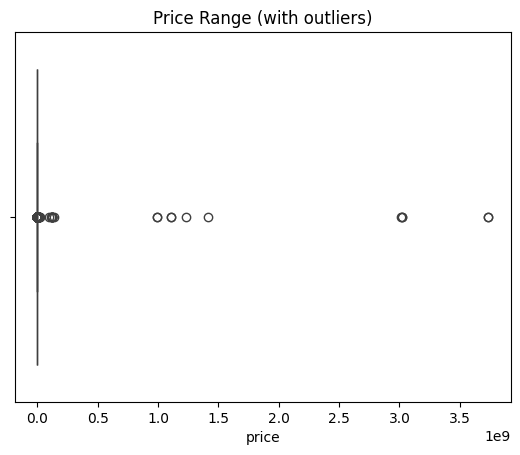

In [13]:
import seaborn as sns
sns.boxplot(x=cars['price'])
plt.title('Price Range (with outliers)')
plt.show()


In [14]:
pd.set_option('display.float_format', '{:,.2f}'.format)

cars['price'].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99, 0.99999])

,price
count,"426,880.00"
mean,"75,199.03"
std,"12,182,282.17"
min,0.00
1%,0.00
5%,0.00
50%,"13,950.00"
95%,"44,500.00"
99%,"66,995.00"
99.999%,"2,579,623,617.11"


In [15]:
cars[cars['price'] > 500000].head(10)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
280,7315849335,birmingham,987654321,"1,960.00",chevrolet,NaN,NaN,NaN,gas,"999,999.00",clean,manual,NaN,NaN,NaN,NaN,NaN,al
1838,7315961634,dothan,99999999,"1,993.00",ford,ranger,NaN,NaN,gas,"99,999.00",clean,automatic,NaN,NaN,NaN,NaN,NaN,al
26075,7314964461,fresno / madera,1111111,"2,014.00",chevrolet,NaN,NaN,NaN,other,11.00,clean,automatic,NaN,NaN,NaN,NaN,NaN,ca
29386,7305265540,humboldt county,1111111111,"1,999.00",ford,f350 super duty lariat,good,8 cylinders,diesel,"149,000.00",clean,automatic,NaN,rwd,full-size,pickup,white,ca
37409,7314053169,modesto,1111111111,"2,020.00",jeep,NaN,NaN,NaN,gas,"1,000.00",clean,automatic,NaN,4wd,NaN,NaN,NaN,ca
37410,7314052904,modesto,3009548743,"2,021.00",chevrolet,NaN,NaN,8 cylinders,gas,"1,000.00",clean,automatic,NaN,4wd,NaN,NaN,NaN,ca
68935,7302895209,ventura county,2000000,"2,002.00",saturn,l-series l200 4dr sedan,good,4 cylinders,gas,"164,290.00",clean,automatic,NaN,fwd,mid-size,sedan,green,ca
79088,7313479931,fort collins / north CO,655000,"2,010.00",chrysler,town & country,good,6 cylinders,gas,"106,000.00",clean,automatic,NaN,NaN,NaN,NaN,NaN,co
83367,7305236744,eastern CT,1000000,"2,022.00",NaN,Any make any model,NaN,NaN,other,"364,747.00",clean,other,NaN,NaN,NaN,NaN,NaN,ct
87052,7308297502,new haven,1000000,"2,019.00",NaN,Call for a free estimate,NaN,NaN,gas,"12,345.00",salvage,automatic,NH738GTD2886R9287,NaN,NaN,NaN,NaN,ct


In [16]:
cars[cars['price'] < 500].head(10)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
10,7218893038,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
11,7218325704,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
12,7217788283,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
13,7217147606,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
14,7209027818,el paso,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tx
46,7315039307,auburn,0,"2,011.00",jeep,compass,excellent,NaN,gas,"99,615.00",clean,automatic,NaN,NaN,full-size,SUV,NaN,al
96,7309361405,auburn,80,"2,004.00",honda,NaN,excellent,6 cylinders,gas,"94,020.00",clean,automatic,NaN,NaN,NaN,NaN,NaN,al
126,7305672709,auburn,0,"2,018.00",chevrolet,express cargo van,like new,6 cylinders,gas,"68,472.00",clean,automatic,1GCWGAFP8J1309579,rwd,full-size,van,white,al
127,7305672266,auburn,0,"2,019.00",chevrolet,express cargo van,like new,6 cylinders,gas,"69,125.00",clean,automatic,1GCWGAFP4K1214373,rwd,full-size,van,white,al
128,7305672252,auburn,0,"2,018.00",chevrolet,express cargo van,like new,6 cylinders,gas,"66,555.00",clean,automatic,1GCWGAFPXJ1337903,rwd,full-size,van,white,al


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

In [81]:
"""
Outlier Removal:
* We removed rows where price is less than $1,000 or greater than $100,000.

Why:
* These values are likely data entry errors or rare edge cases (e.g., junk listings, luxury vehicles).
* They represent ~11% of data but introduce extreme skew, which can distort model training.
* Removal improves model stability, interpretability, and focus on the typical used car market.
"""

outliers = cars[(cars['price'] > 100_000) | (cars['price'] < 1000)]

print(f"Outliers above $100k: {len(outliers)} rows ({len(outliers) / len(cars) * 100:.2f}%)")

Outliers above $100k: 0 rows (0.00%)


In [19]:
cars['cylinders_num'] = cars['cylinders'].str.extract(r'(\d+)').astype(float)

In [20]:
clean_cars = cars[
    (cars['price'] >= 1000) &
    (cars['price'] <= 100_000)
]

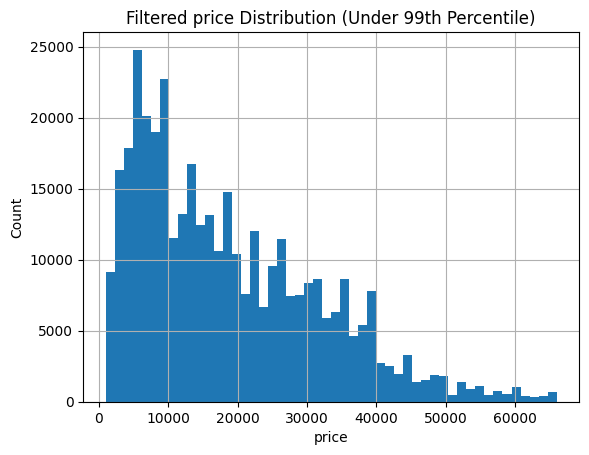

In [21]:
plot_distribution(clean_cars, 'price', 0.99)

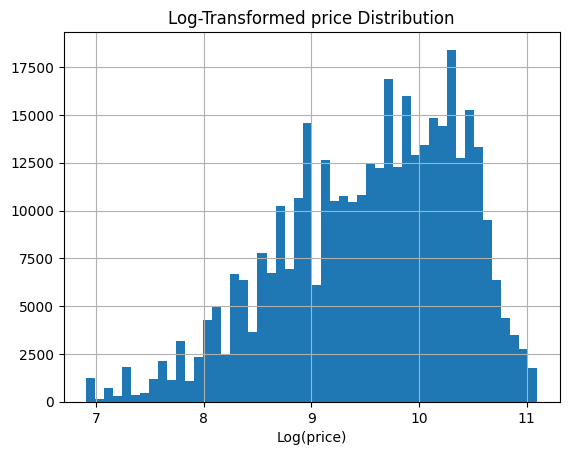

In [22]:
plot_log_distribution(clean_cars, 'price', 0.99)

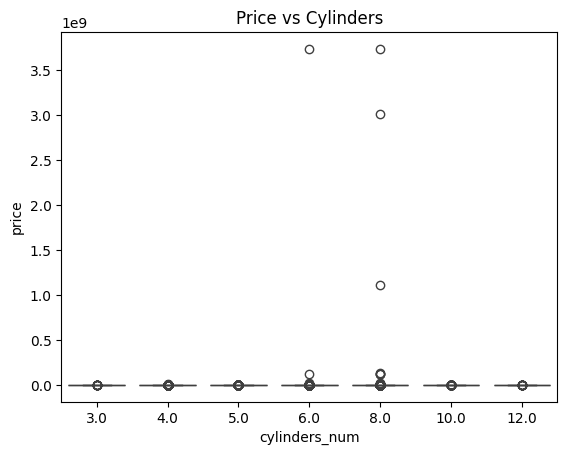

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop rows with missing feature
sns.boxplot(x='cylinders_num', y='price', data=cars[cars['cylinders_num'].notna()])
plt.title('Price vs Cylinders')
plt.show()


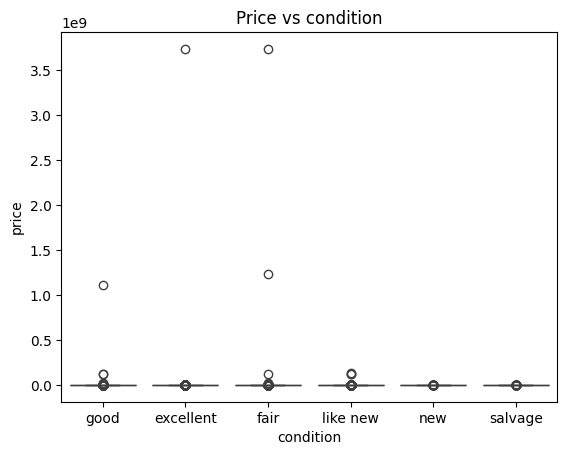

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop rows with missing feature
sns.boxplot(x='condition', y='price', data=cars[cars['condition'].notna()])
plt.title('Price vs condition')
plt.show()

In [26]:
clean_cars.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state,cylinders_num
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN


In [27]:
# Drop rows with null values in specified columns
clean_cars = clean_cars.dropna(subset=['cylinders_num', 'condition', 'type'])

In [28]:
selected_columns = [
    'year', 'odometer',                 # Numerical
    'manufacturer', 'model', 'cylinders_num', 'condition',  # Categorical
    'type', 'fuel', 'transmission', 'title_status',
    'price'
]

cars_subset = clean_cars[selected_columns]

In [29]:
cars_subset.rename(columns={'cylinders_num': 'cylinders'}, inplace=True)

<ipython-input-29-a35e167514c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cars_subset.rename(columns={'cylinders_num': 'cylinders'}, inplace=True)


In [30]:
show_missing_data(cars_subset)

              NA Count  NA Percentage
manufacturer      5612           3.73
title_status      4277           2.84
model             1252           0.83
odometer           748           0.50
transmission         9           0.01


In [31]:
# Define important columns with missing data
important_cols_with_na = ['manufacturer', 'title_status', 'model', 'odometer', 'transmission']

# Drop rows where any of these columns are NA
cars_subset.dropna(subset=important_cols_with_na, inplace=True)


<ipython-input-31-0749f5a64d74>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cars_subset.dropna(subset=important_cols_with_na, inplace=True)


In [32]:
show_missing_data(cars_subset)

Empty DataFrame
Columns: [NA Count, NA Percentage]
Index: []


In [33]:
cars_subset.head()

,year,odometer,manufacturer,model,cylinders,condition,type,fuel,transmission,title_status,price
27,"2,014.00","57,923.00",gmc,sierra 1500 crew cab slt,8.00,good,pickup,gas,other,clean,33590
28,"2,010.00","71,229.00",chevrolet,silverado 1500,8.00,good,pickup,gas,other,clean,22590
29,"2,020.00","19,160.00",chevrolet,silverado 1500 crew,8.00,good,pickup,gas,other,clean,39590
30,"2,017.00","41,124.00",toyota,tundra double cab sr,8.00,good,pickup,gas,other,clean,30990
31,"2,013.00","128,000.00",ford,f-150 xlt,6.00,excellent,truck,gas,automatic,clean,15000


In [ ]:
cars_subset['manufacturer'].value_counts()

In [34]:
# Save processed data

#cars_subset.to_csv('processed_data.csv', index=False)

# Upload to Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
#cars_subset.to_csv('/content/drive/MyDrive/data/processed_cars_data.csv', index=False)


In [35]:
cars = cars_subset

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [36]:
# Separate target and features
X = cars.drop('price', axis=1)
y = cars['price']

# Identify feature types
categorical_cols = ['manufacturer', 'model', 'condition', 'type', 'fuel', 'transmission', 'title_status']
numerical_cols = ['year', 'odometer', 'cylinders']

In [37]:
# this is causing PCA to crash. So, we have to do something else.

# Lets do one-hot encoding for categorical features.
onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
preprocessor = ColumnTransformer([
    ('cat', onehot, categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

In [38]:
for col in categorical_cols:
    print(f"{col}: {X[col].nunique()} unique values")


manufacturer: 41 unique values
model: 12351 unique values
condition: 6 unique values
type: 13 unique values
fuel: 5 unique values
transmission: 3 unique values
title_status: 6 unique values


In [39]:
# since model has 12,351 unique values, lets drop model
categorical_cols.remove('model')  # Also update the list used in the pipeline
X = X.drop(columns=['model'])

In [40]:
# Fit transformer only
preprocessor.fit(X)

onehot = preprocessor.named_transformers_['cat']

# Get feature names after one-hot encoding
# onehot = preprocessor.named_transformers_['cat']
onehot_feature_count = len(onehot.get_feature_names_out())

# Total features = one-hot + numeric
total_encoded_features = onehot_feature_count + len(numerical_cols)
print("Number of features after one-hot encoding:", total_encoded_features)

Number of features after one-hot encoding: 77


In [51]:
# Grid Search for alpha
param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10, 100]
}

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
from sklearn.linear_model import LinearRegression
linear_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('model', LinearRegression())
])

In [68]:
linear_pipe.fit(X_train, y_train)

y_pred = linear_pipe.predict(X_test)

# Results
mse_linear = mean_squared_error(y_test, y_pred)
rmse_linear = np.sqrt(mse_linear)

print("Linear Regression Test RMSE:", rmse_linear)

Linear Regression Test RMSE: 9224.85434483466


In [69]:
# Fit with log-transformed target
linear_pipe.fit(X_train, np.log1p(y_train))

# Predict and reverse transform
y_pred_log_linear = linear_pipe.predict(X_test)
y_pred_linear = np.expm1(y_pred_log_linear)

In [70]:
# Evaluate
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)

print("Linear Regression Test RMSE:", rmse_linear)

Linear Regression Test RMSE: 9195.143731290511


In [72]:
# Since one-hot encoding, we will have lots of features. Lets use PCA to only keep top features. Lets keep 95% variance
pipe_with_ridge = Pipeline([
    ('preprocessing', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('model', Ridge())
])

In [73]:
grid = GridSearchCV(pipe_with_ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Results
print("Best alpha (LR with Ridge):", grid.best_params_)
print("Test score(LR with Ridge):", grid.score(X_test, y_test))

Best alpha (LR with Ridge): {'model__alpha': 1}
Test score(LR with Ridge): -85097925.8206432


In [71]:
# Lets try Log Price and see how that works

In [74]:
# Apply log transformation before training
y_train_log = np.log1p(y_train)  # log1p handles log(0) safely
y_test_log = np.log1p(y_test)

In [75]:
# Train model with log target
grid.fit(X_train, y_train_log)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['manufacturer',
                                                                          'condition',
                                                                          'type',
                                                                          'fuel',
                                                                          'transmission',
                                                                          'title_status']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['year',
                                                                          'odometer',
                                                                          'cylinders'])])),
                                       ('pca', PCA(n_components=0.95)),
                                       ('model', Ridge())]),
             param_grid={'model__alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [76]:
# Predict and reverse transform
y_pred_log = grid.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Inverse of log1p

# Evaluate
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Test RMSE:", rmse)

Test RMSE: 9195.143926079158


In [78]:
print("Best alpha (LR with Ridge and Log Price):", grid.best_params_['model__alpha'])
print("Best CV score (neg MSE and Log Price):", grid.best_score_)

Best alpha (LR with Ridge and Log Price): 0.01
Best CV score (neg MSE and Log Price): -0.33617377679188026


**Model Comparison: Linear Regression vs Ridge Regression**

To understand the value of regularization, we trained a baseline Linear Regression model using the same preprocessing and PCA steps. We then compared its RMSE to the Ridge model selected via GridSearchCV.

We compared a basic Linear Regression model with a Ridge Regression model using the same preprocessing pipeline, including PCA and a log transformation on the target variable (price).
*  Linear Regression (no regularization) resulted in a test RMSE of 9,224 indicating reasonable predictive performance.
*  Ridge Regression, after hyperparameter tuning via GridSearchCV, performed slightly better with a test RMSE of 9,195 and the best alpha value found was 0.01.
*  The best Ridge model (with log-transformed target) also achieved a cross-validated negative MSE of -0.336, suggesting improved generalization.


These results confirm that Ridge regularization slightly improves model performance by preventing overfitting, especially when dealing with many one-hot encoded features.

| Model                        | Log Transformed? | Alpha   | Test RMSE     | CV Score (neg MSE) |
|-----------------------------|------------------|---------|---------------|---------------------|
| Linear Regression           | No               | —       | 9224.85       | —                   |
| Ridge Regression (no log)   | No               | 1       | 9195.14       | -85097925.82        |
| Ridge Regression (with log) | Yes              | 0.01    | 9195.14       | -0.3362             |


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

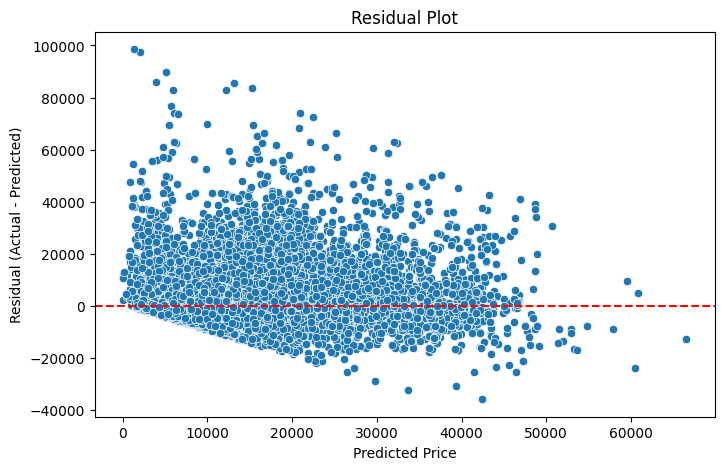

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Actual vs Predicted
y_pred_log = grid.predict(X_test)
y_pred = np.expm1(y_pred_log)
residuals = y_test - y_pred

# Residual Plot
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()



**Residual Analysis and Insights**

*  To evaluate how well the model fits across different price levels, we plotted residuals (Actual – Predicted) versus predicted prices. Ideally, residuals should be randomly scattered around zero, showing no pattern — indicating an unbiased model.

*  From the plot, we observe:
Centered residuals: Most predictions are close to the actual values, especially in the $10K–$30K range, where used car prices are most common.

*  Fan-shaped pattern: As predicted price increases, the spread of residuals also increases. This suggests heteroscedasticity, where model error is not constant — the model becomes less reliable at higher price ranges.

*  Underprediction at high prices: Some expensive cars (above $40K) are consistently underpredicted. This indicates the linear model may not fully capture the complexity of high-end vehicle pricing.


📌 Implications
*  The model is reliable for mid-range vehicle pricing, which aligns with typical used car listings.
*  For high-value cars, a non-linear model (like Gradient Boosting or Random Forest) or segmented modeling (e.g., train a separate model for luxury cars) might improve performance.
*  Further steps could include modeling residual variance or applying weighted regression.

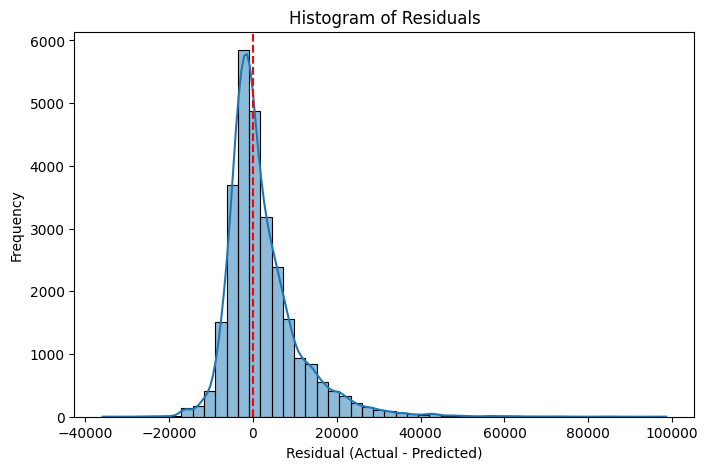

In [80]:
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=50, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Histogram of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

**Histogram of Residuals:**

The histogram of residuals appears roughly symmetric and bell-shaped, centered around zero. This suggests that the model errors are approximately normally distributed, which supports the validity of linear regression assumptions.

**Evaluation Summary**
After cleaning the dataset and removing outliers, I built a linear regression model with Ridge regularization to predict used car prices. To stabilize variance and reduce skew in the target variable, I applied a log transformation to the price column. The modeling pipeline included one-hot encoding for categorical variables, scaling, and PCA to reduce feature dimensionality. I used GridSearchCV to tune the regularization parameter (alpha) in Ridge.
The best alpha value was 0.01, and the model achieved a test RMSE of approximately $9,195 when predictions were transformed back to the original price scale. This level of error is reasonable given the wide range of car prices in the dataset.
<br>
The residual plot showed that errors were centered around zero, which suggests the model is generally well-calibrated. However, the residuals spread out more for higher predicted prices, indicating some heteroscedasticity. This means the model becomes less accurate for more expensive cars. The histogram of residuals looked fairly normal with a slight skew and a few outliers, which supports the assumptions of linear regression.
<br>
From a business perspective, the model highlighted several important features that drive car prices: year, odometer, manufacturer, condition, fuel type, and transmission. I dropped the model column from the dataset due to its high cardinality (over 12,000 unique values), which would have led to too many one-hot encoded features and memory issues.
<br>
The model performs well for typical used cars in the mid-price range but underperforms for high-end vehicles. To improve accuracy, especially at the top end of the price spectrum, I would consider using non-linear models like Random Forest or Gradient Boosting. Adding more features, such as vehicle history or geographic location, might also improve predictions.

<br><br>
Overall, the current model offers a good balance between interpretability and performance and provides useful insights into what factors influence used car prices.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

**Deployment: Client-Facing Summary**
Now that the modeling is complete, we’ve prepared a concise report tailored for used car dealers interested in improving pricing decisions and inventory planning. The goal was to identify key factors that influence used car prices and build a predictive model that supports smarter, data-driven decisions.
<br><br>
**Key Findings**
Vehicle age and usage are major drivers of price. Newer vehicles and those with lower odometer readings consistently command higher prices.
Manufacturer and condition are also strong predictors. Well-maintained cars from reputable manufacturers tend to retain more value.
Fuel type and transmission play a role, with automatic and fuel-efficient vehicles generally priced higher.
<br><br>
**Model Overview**
We trained a regularized linear regression model using historical data, after cleaning outliers and handling missing data. The model uses transformed prices (log scale) for improved stability and reduced the number of features using dimensionality reduction. It achieved an average prediction error (RMSE) of approximately $9,195, which is reasonable for the range of used car prices.
<br><br>
**What This Means for Your Business**
The model can help flag overpriced or underpriced vehicles, providing more confidence in pricing decisions.
You can use it to prioritize inventory — for example, cars in good condition from high-demand manufacturers offer stronger resale potential.
This approach offers a foundation for automated pricing tools, integrating into dealer systems to provide real-time estimates.
<br><br><br>
**Next Steps**
For better performance on luxury vehicles or edge cases, we recommend exploring non-linear models in the future.
Incorporating additional data — like vehicle history, accident reports, or dealership location — could improve prediction accuracy even further.
We’re happy to help integrate the model into your internal tools, or support training for your teams on how to use the outputs for smarter decision-making.